In [227]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS 
from matplotlib import pyplot as plt 
import io
from google.colab import files
from PIL import Image
import seaborn as sns
# df.to_csv('df.csv')
# files.download('df.csv')

In [228]:
# 1
url = "https://raw.githubusercontent.com/ShellBracken/cse351_assignment1/main/AB_NYC_2019.csv"
df = pd.read_csv(url)

# Removed last_review column as too many entries missing to extrapolate from
df = df.drop('last_review', 1)

# Removed Airbnb listings with 0 availibility out of 365 days
df.drop(df[df.availability_365 == 0].index, inplace=True)

# Filled missing values under 'reviews_per_month' with 0 as corresponding 'number_of_reviews' equal 0
df.fillna(value={'reviews_per_month':0}, inplace=True)
print(df)

             id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
5          5099  ...              129
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[31362 rows x 15 columns]


['Hunts Point', 'Soundview', 'Bronxdale', 'Tremont', 'Grant City']
['Riverdale', 'Tribeca', 'Battery Park City', 'Flatiron District', 'Randall Manor']
{'Kensington': 98.93137254901961, 'Midtown': 302.2907083716651, 'Harlem': 129.64302191464822, 'Clinton Hill': 206.28571428571428, 'Murray Hill': 231.18032786885246, "Hell's Kitchen": 213.18326417704012, 'Chinatown': 178.08849557522123, 'Upper West Side': 239.28374655647383, 'South Slope': 150.26190476190476, 'Williamsburg': 161.09259259259258, 'Fort Greene': 158.3275261324042, 'Chelsea': 264.40651558073654, 'Crown Heights': 128.28618421052633, 'East Harlem': 133.02445652173913, 'Park Slope': 198.57093425605535, 'Bedford-Stuyvesant': 115.16881547139404, 'Windsor Terrace': 142.3978494623656, 'Inwood': 94.25641025641026, 'East Village': 202.12434691745037, 'Greenpoint': 153.7965811965812, 'Bushwick': 91.28295376121463, 'Flatbush': 97.83923705722071, 'Lower East Side': 215.59245283018868, 'Prospect-Lefferts Gardens': 122.46153846153847, 'Lon

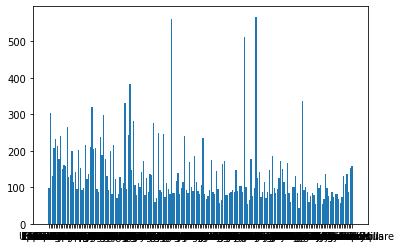

In [229]:
# 2
# Creates dictionary of neighbourhoods as keys and list to contain total price, number of listings, and mean as value
nbhd = df['neighbourhood'].tolist()
nbhd = { i : [0, 0, 0] for i in nbhd }
for i, row_value in df['price'].iteritems():
  nb = df['neighbourhood'][i]
  nb_arr = nbhd.get(nb)
  nb_arr[0] += row_value
  nb_arr[1] += 1

# Removes neighbourhoods without more than 5 listings from dict
del_list = []
for key in nbhd:
  nb_arr = nbhd.get(key)
  if nb_arr[1] <= 5:
    del_list.append(key)
for x in del_list:
  del nbhd[x]

# Calculates neighbourhood mean and inputs into third index of array at dictionary
for key in nbhd:
  nb_arr = nbhd.get(key)
  nb_arr[2] = nb_arr[0] / nb_arr[1]
  nbhd[key] = nb_arr[2]

# List of neighbourhood means turned values sorted
dict_val = list(nbhd.values())
dict_val.sort()

bot_five = []
top_five = []
# Bottom 5 neighborhoods in increasing order: Hunts Point, Soundview, Bronxdale, Tremont, Grant City
for i in range(5):
  for key in nbhd:
    if nbhd[key] == dict_val[i]:
      bot_five.append(key)
print(bot_five)
# Top 5 neighborhoods in decreasing order: Riverdale, Tribeca, Battery Park City, Flatiron District, Randall Manor
for i in range(5):
  for key in nbhd:
    if nbhd[key] == dict_val[len(dict_val) - 1 - i]:
      top_five.append(key)
print(top_five)

print(nbhd)
neighbourhoods = list(nbhd.keys())
prices = list(nbhd.values())

# Price variation plot
plt.bar(range(len(nbhd)),prices,tick_label=neighbourhoods)
plt.savefig('plot.png')
plt.show()

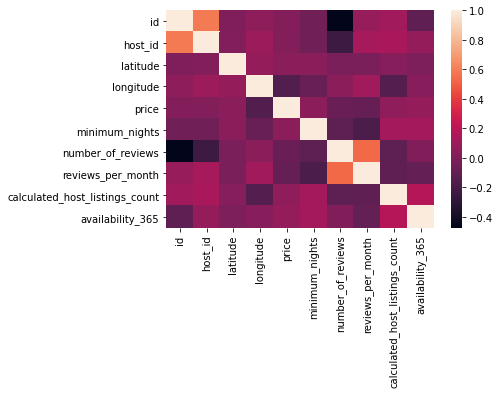

In [230]:
# 3
correlations = df.corr(method ='pearson')
sns.heatmap(correlations)
plt.show()

# There are strong negative correlations between number of reviews and price as well as minimum nights, as
# likely with a higher nightly price or number of minimum nights the smaller number of customers will be
# due to being priced out or unwilling to book more nights than needed. There also may be a negative
# correlation between minimum number of nights and price as Airbnb hosts may wish to set a higher
# number of minimum nights to offset the lower price and ensure more reliable, profitable stays

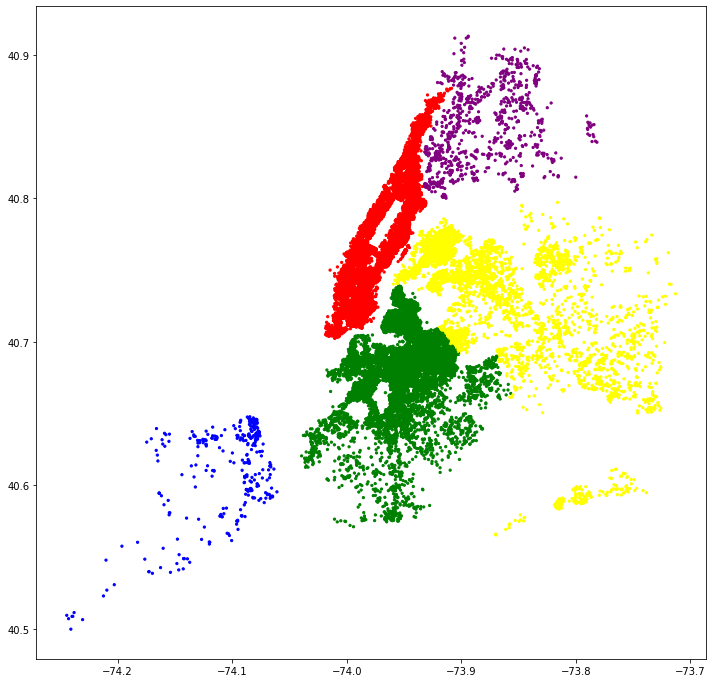

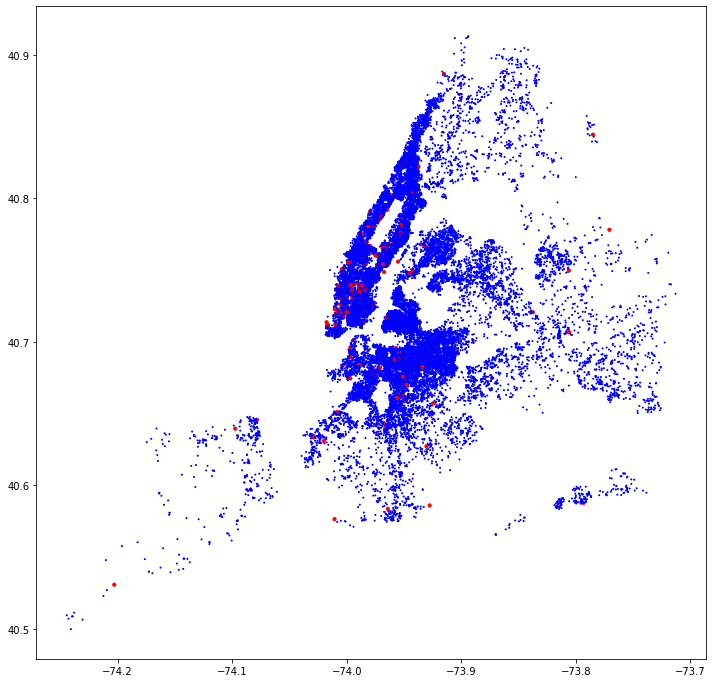

In [231]:
# 4

# The first scatterplot maps plot points geographically and color codes based off their
# neighborhood areas, the following color_dict dictionary shows which color denotes which area
fig, ax = plt.subplots(figsize=(12,12))
color_dict = {'Manhattan':'red', 'Brooklyn':'green', 'Queens':'yellow', 'Staten Island':'blue', 'Bronx':'Purple'}
ax.scatter(x=df['longitude'], y=df['latitude'], c=df['neighbourhood_group'].map(color_dict), s=5)
fig2, ax2 = plt.subplots(figsize=(12,12))

def price_func(x):
  if x < 1000:
    return 'blue'
  return 'red'

def mark_func(x):
  if x < 1000:
    return 1
  return 10

# For the second scatterplot, the red plot points denote the Airbnb listings over a price of a 1000 per month, while 
# the blue points denote the rest
ax2.scatter(x=df['longitude'], y=df['latitude'], c=df['price'].map(price_func), s=df['price'].map(mark_func))
plt.show()

# From the graph the neighbourhood group Manhattan is clearly the most expensive. However, this may be a little 
# hard to see as the number of $1000+ listings is tightly clustered by other properties on the packed island

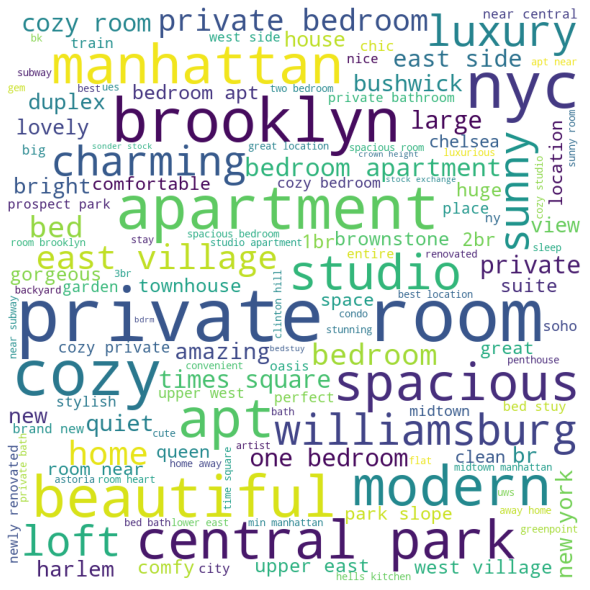

In [232]:
# 5
# Places all name column entries into list and joins into string with space-separation
names = df['name'].tolist()
names = " ".join(str(name) for name in names)

# Removes all non-alphanumeric characters from space-concatenated string of all names while 
# initially replacing some non-alphanumeric characters with spaces to ensure word separation 
remove = ',_-.:/?!*()'
for i in remove:
    names = names.replace(i, ' ')
names = ''.join([char for char in names if char.isalpha() or char.isdigit() or char == ' '])

# Removes extra spaces
names = ' '.join(names.split())

# Changes all alphabetic characters to lowercase
names = names.lower()

# Randomly generates wordcloud with previous names string
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 11).generate(names)
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()
